In [1]:
import os
import numpy as np
import pandas as pd

from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

pd.options.mode.chained_assignment = None

In [2]:
import sys
sys.path.append('../../Python/')
from Preprocessing import standardize, MaxMinScaler
from Evaluation import split_train_test_ma, eval_model, split_train_test_ma_rd, train_model, eval_model_roc_2
from Databases import get_databases_path, get_database

In [3]:
def FrobeniusProduct(A,B):
    return np.dot(A.T,B).trace()

def solve_problem(H, f, annotators):
    P = matrix(H)
    q = matrix(f)
    G = -matrix(np.eye(annotators))
    h = matrix(np.zeros((annotators,1)))
    sol = solvers.qp(P,q,G,h)
    v = sol['x']
    mu = np.array(v/LA.norm(v))
    return mu
    
def train_ka_model(X_train, y_train, X_test):
    annotators = y_train.columns.size
    KXX = np.dot(X_train, X_train.T)

    Y = {}
    for annotator in y_train.columns:
        Y[annotator] = pd.get_dummies(y_train[annotator])

    m = X_train.shape[0]
    MOnes = np.ones((m,1))
    aux_1 = np.eye(m) - np.dot(MOnes,(MOnes.T)/m)
    KXXc = np.dot(aux_1, KXX, aux_1)

    KYYc = {}
    KYY = {}
    a = np.array([])
    for annotator in y_train.columns:
        KYY[annotator] = np.dot(Y[annotator], Y[annotator].T)
        KYYc[annotator] = aux_1 * KYY[annotator] * aux_1
        a = np.append(a, FrobeniusProduct(KYYc[annotator], KXXc))

    M = np.zeros((annotators, annotators))
    for idA, annotator_a in enumerate(y_train.columns):
        for idB, annotator_b in enumerate(y_train.columns):
            M[idB, idA] = FrobeniusProduct(KYYc[annotator_b], KYYc[annotator_a]); 

    H = 2*M
    f = -2*a

    mu = solve_problem(H, f, annotators)

    models = {}
    for annotator in y_train.columns:
        models[annotator] = train_model(X_train, y_train[annotator])

    final_weight = np.zeros((X_test.shape[0],1))
    for idx, annotator_a in enumerate(y_train.columns):
        probs = models[annotator].predict_proba(X_test)
        true_class_prob = probs[:,0]
        annotator_weight = (true_class_prob*mu[idx]).reshape((X_test.shape[0],1))
        final_weight += annotator_weight
    final_weight = final_weight/mu.sum()
    return final_weight

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/breast-cancer 

     pcost       dcost       gap    pres   dres
 0: -2.4722e+04 -2.4723e+04  3e-01  0e+00  1e-05
 1: -2.4722e+04 -2.4722e+04  3e-03  3e-17  1e-07
 2: -2.4722e+04 -2.4722e+04  3e-05  7e-18  1e-09
Optimal solution found.

Results

-- Global Precision --
0.9181286549707602


-- General Report --
              precision    recall  f1-score   support

         yes       0.92      0.95      0.94       108
          no       0.92      0.86      0.89        63

    accuracy                           0.92       171
   macro avg       0.92      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171



-- Confusion Matrix --
     0   1
0  103   5
1    9  54

ROC Curve: 

ROC AUC:  0.9797178130511464


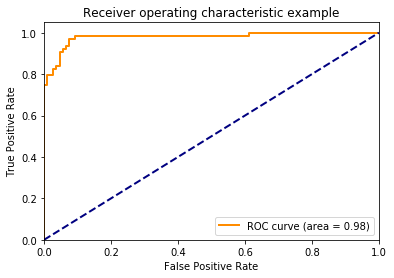

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/column 

     pcost       dcost       gap    pres   dres
 0: -2.6718e+02 -2.6849e+02  1e+00  0e+00  3e-03
 1: -2.6718e+02 -2.6720e+02  1e-02  8e-17  4e-05
 2: -2.6718e+02 -2.6718e+02  1e-04  2e-16  4e-07
 3: -2.6718e+02 -2.6718e+02  1e-06  2e-16  4e-09
Optimal solution found.

Results

-- Global Precision --
0.7526881720430108


-- General Report --
              precision    recall  f1-score   support

         yes       0.79      0.87      0.83        63
          no       0.65      0.50      0.57        30

    accuracy                           0.75        93
   macro avg       0.72      0.69      0.70        93
weighted avg       0.74      0.75      0.74        93



-- Confusion Matrix --
    0   1
0  55   8
1  15  15

ROC Curve: 

ROC AUC:  0.8179894179894179


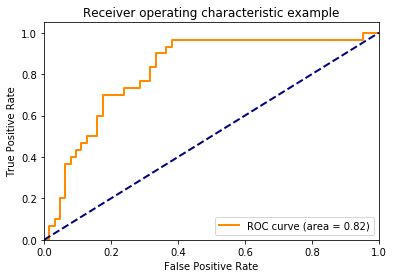

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/parkinsons 

     pcost       dcost       gap    pres   dres
 0: -2.5143e+03 -2.5145e+03  5e+00  2e+00  4e-05
 1: -2.5143e+03 -2.5145e+03  2e-01  3e-02  7e-07
 2: -2.5143e+03 -2.5144e+03  8e-02  1e-02  2e-07
 3: -2.4814e+03 -2.5372e+03  6e+01  4e-03  7e-08
 4: -2.0503e+03 -3.0657e+03  1e+03  3e-03  6e-08
 5: -2.0454e+03 -3.2647e+03  1e+03  2e-03  5e-08
 6: -2.4457e+03 -3.0558e+03  6e+02  2e-17  1e-15
 7: -2.5018e+03 -2.5632e+03  6e+01  1e-17  8e-17
 8: -2.5123e+03 -2.5175e+03  5e+00  2e-17  7e-17
 9: -2.5134e+03 -2.5137e+03  3e-01  1e-17  8e-17
10: -2.5136e+03 -2.5136e+03  5e-03  2e-17  4e-17
11: -2.5136e+03 -2.5136e+03  5e-05  8e-18  4e-17
Optimal solution found.

Results

-- Global Precision --
0.8983050847457628


-- General Report --
              precision    recall  f1-score   support

         yes       0.92      0.96      0.94        46
          no       0.82      0.69

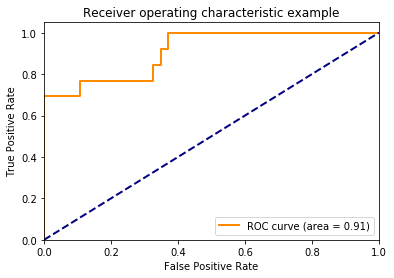

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/ionophere 

     pcost       dcost       gap    pres   dres
 0: -9.0670e+03 -9.0671e+03  6e+00  2e+00  1e-05
 1: -9.0670e+03 -9.0670e+03  2e-01  8e-02  4e-07
 2: -9.0670e+03 -9.0669e+03  1e-01  6e-02  3e-07
 3: -8.4274e+03 -7.9545e+03  1e+03  5e-02  2e-07
 4: -7.4456e+03 -7.0708e+03  3e+03  5e-02  2e-07
 5: -6.9997e+03 -6.0714e+03  5e+03  5e-02  2e-07
 6:  1.5515e+03 -8.9058e+03  2e+04  1e-02  6e-08
 7: -3.1918e+03 -5.1663e+03  2e+03  1e-17  7e-15
 8: -4.6622e+03 -4.8433e+03  2e+02  7e-18  2e-16
 9: -4.8255e+03 -4.8280e+03  2e+00  7e-18  3e-16
10: -4.8279e+03 -4.8279e+03  2e-02  7e-18  4e-16
11: -4.8279e+03 -4.8279e+03  2e-04  7e-18  3e-16
Optimal solution found.

Results

-- Global Precision --
0.819047619047619


-- General Report --
              precision    recall  f1-score   support

         yes       0.78      0.68      0.72        37
          no       0.84      0.90  

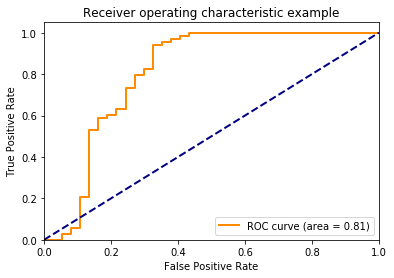

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/sentiment-polarity 

     pcost       dcost       gap    pres   dres
 0: -6.6914e+02 -6.6944e+02  3e-01  0e+00  3e-04
 1: -6.6914e+02 -6.6914e+02  3e-03  1e-17  3e-06
 2: -6.6914e+02 -6.6914e+02  3e-05  3e-17  3e-08
Optimal solution found.

Results

-- Global Precision --
0.38095238095238093


-- General Report --
              precision    recall  f1-score   support

         yes       0.36      0.46      0.40        48
          no       0.41      0.32      0.36        57

    accuracy                           0.38       105
   macro avg       0.38      0.39      0.38       105
weighted avg       0.39      0.38      0.38       105



-- Confusion Matrix --
    0   1
0  22  26
1  39  18

ROC Curve: 

ROC AUC:  0.33333333333333326


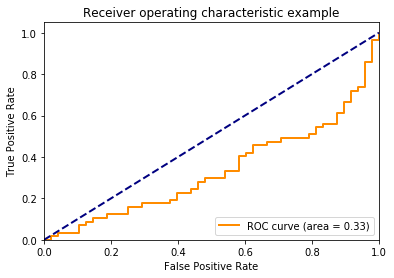

In [4]:
databases_path = '../../Databases/Sinteticas'
paths = get_databases_path(databases_path)

for idx, database in enumerate(paths):
    print('------------------------------------------------------------------------')
    print("Database:", database, '\n')
    
    # Obtain the attributes and labels
    attr_df = get_database(database, 'database_attr.csv')
    labels_df = get_database(database, 'database_labels.csv')

    if idx != 4: attr_df = MaxMinScaler(attr_df)

    # Split in Training and Test Sets
    X_train, X_test, y_train, y_test = split_train_test_ma(attr_df, labels_df)

    predTest = train_ka_model(X_train, y_train, X_test)
    y_pred = np.round(predTest).astype(bool)

    print("\nResults\n")
    eval_model_roc_2(y_test, y_pred, predTest)